-------------------------------------------------------------------------------------------------------------------
Implementation of : "Online Label Recovery for Deep Learning-based communication through Error Correcting codes"

Author : Eric Soubigou

Date : Spring 2019

-------------------------------------------------------------------------------------------------------------------

Description :  Creation of a DFE like with Deep Learning technologies

In [16]:
# Install libraries :
!pip3 install --user --upgrade pip
!pip3 install --user scipy matplotlib matplotlib2tikz torch
!pip3 install --user git+git://github.com/veeresht/CommPy.git@master
print("================== DONE ! ==================")

Requirement already up-to-date: pip in /home/eric/.local/lib/python3.6/site-packages (19.1.1)
  Cloning git://github.com/veeresht/CommPy.git (to revision master) to /tmp/pip-req-build-comtjm98
  Running command git clone -q git://github.com/veeresht/CommPy.git /tmp/pip-req-build-comtjm98
  Stored in directory: /tmp/pip-ephem-wheel-cache-px9cg_z1/wheels/d1/6a/31/8ddc70e8eb8a1c3ad344032ed43b4ebfccc41007e8850226d0
Successfully built scikit-commpy
================== DONE ! ==================


In [17]:
## To modify the code while running the notebook whitout any restart
%load_ext autoreload
%autoreload 2

In [3]:
from __future__ import print_function

# Numpy
import numpy as np
np.set_printoptions(precision=2)

# For DL libraries 
import torch
import torch.nn as nn
import torch.nn.functional as F

# Set the use of device which will be used 
if torch.cuda.is_available():
    device = torch.device('cuda')
    FloatTensor = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    FloatTensor = torch.FloatTensor


The next cell handles simulation for a standard MMSE/ZF OFDM scheme. "simulation_param_dict" is the dictionary which will handles the simulations parameters. 

Nota : It is important to take time in order to set every parameter as wanted even "channel_type" because the output file of performances will be named depending on those parameters. So if some file already exist with the same name, it will overwrite them.

In [ ]:
# Launch simulation
from MonteCarlo import *

simulation_param_dict = {
    "m_c_parameters": {
        "min_error_frame": 100,
        "targeted_fer": 1e-2,
        "step_db": 2,
        "min_eb_n0": 0,
        "max_eb_n0": 50,
    },
    "channel_parameters": {
        "channel_type": "Proakis_C",
        "non_lin_coeff": 0,
        "iq_imbalance": None,
        "channel_taps": np.array([1, 2, 3, 2, 1]),
    },
    "frame_length": 256,
    "modulation": {
        "modulation_order": 4,
        "nb_carriers": 64,
        "cp_length": 8,
        "off_carrier": 0,
    },
    "equalizer": "MMSE",
    "channel_coding": {
        "mem_size": np.array([2]),
        "g_matrix": np.array([[0o5, 0o7]]),
        "rho": 1 / 2,  #  Coding rate
    },
    "pre_equalizer": {
        "model_path": None,
        "feed_back_freq": 0,
    }
}

# Launch the simulation
monte_carlo_simulation(simulation_param_dict)

In [73]:
from DataSetManager import *

# Data set Creation
data_set_generation_param_dict = {
    "eb_n0_db": 50,
    "channel_parameters": {
        "channel_type": "Proakis_C",
        "non_lin_coeff": 0.5,
        "iq_imbalance": 0.5,
        "channel_taps": np.array([1, 2, 3, 2, 1]),
    },
    "frame_length": 6000060,#2000140, # 1000040
    "modulation": {
        "modulation_order": 4,
        "nb_carriers": 64,
        "cp_length": 8,
        "off_carrier": 0,
    },
    "equalizer": "MMSE",
    "channel_coding": {
        "mem_size": np.array([2]),
        "g_matrix": np.array([[0o5, 0o7]]),
        "rho": 1 / 2,  #  Coding rate
    },
}

create_data_set(data_set_generation_param_dict)

shape comparison samples and targets (105470, 72) (105470, 72)
Data set created at ./data_set/OFDM_non_lin_coeff_0.5_iq_im_0.5_eb_n0_50_Proakis_C.pt


Splitting of data set: 
	Training set size : 168752/210940 
	Validation set size : 21094/210940 
	Test set size : 21094/210940

Can't load ./models/pre_eq_model_proakis_C_20_30dB.pth => Generate a new model

Epoch 500/500; training MSE : 0.0008488573948852718; validation MSE : 0.0008497940725646913

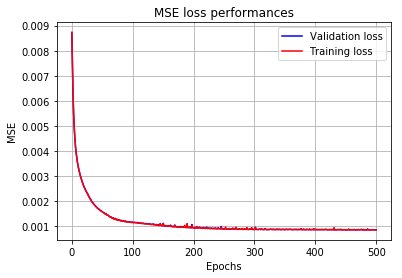

Performances of the training saved at ./models/pre_eq_model_proakis_C_20_30dB_training_perf.pickle


In [12]:
#  Train the NN-prequlizer
from PreEqualizer import *
from DataSetManager import *
from torch.utils.data import DataLoader

# Load the data set
data_set = OFDMSamplesDataset(
    #"./data_set/OFDM_non_lin_coeff_0.5_iq_im_0.5_eb_n0_50_Proakis_C.pt",
    #"./data_set/OFDM_non_lin_coeff_0.5_iq_im_0.5_eb_n0_25_Proakis_C.pt",
    #"./data_set/OFDM_non_lin_coeff_0.5_iq_im_0.5_eb_n0_40_Proakis_C.pt",
    "./data_set/OFDM_non_lin_coeff_0.5_iq_im_0.5_eb_n0_30_Proakis_C.pt",
    "./data_set/OFDM_non_lin_coeff_0.5_iq_im_0.5_eb_n0_20_Proakis_C.pt",
    #"./data_set/OFDM_non_lin_coeff_0.5_iq_im_0.5_eb_n0_15_Proakis_C.pt",
    #"./data_set/OFDM_non_lin_coeff_0.5_iq_im_0.5_eb_n0_10_Proakis_C.pt",
)


# Spliting policies
training_size = int(0.8 * len(data_set))
validation_size = int(0.1 * len(data_set))
test_size = int(0.1 * len(data_set))

print(
    "Splitting of data set: \n\tTraining set size : {}/{} \n\tValidation set size : {}/{} \n\tTest set size : {}/{}\n".format(
        str(training_size),
        str(len(data_set)),
        str(validation_size),
        str(len(data_set)),
        str(test_size),
        str(len(data_set)),
    )
)

# Split data set
training_set, validation_set, test_set = torch.utils.data.random_split(
    data_set, [training_size, validation_size, test_size]
)

# Create a data loaders...
batch_size_set = 10000
nb_epochs = 500

training_dataloader = DataLoader(
    dataset=training_set, batch_size=batch_size_set, shuffle=False
)
validation_dataloader = DataLoader(
    dataset=validation_set, batch_size=batch_size_set, shuffle=False
)

# Creation of the PreEqualizer
model_path = "./models/pre_eq_model_proakis_C_20_30dB.pth"
path_training = "./models/pre_eq_model_proakis_C_20_30dB_training_perf.pickle"

pre_eq = PreEqualizer(data_set.get_number_of_carriers())

try:
    pre_eq.load_state_dict(torch.load(model_path))
except:
    print("Can't load {} => Generate a new model\n".format(model_path))

# Train the Pre-Equalizer in standalone mode
PreEqualizer.train(
    pre_eq,
    training_dataloader,
    validation_dataloader,
    nb_epochs=nb_epochs,
    path_training=path_training,
    sgd_step=0.001,
)

# Save the model after training
torch.save(pre_eq.state_dict(), model_path)

Results will be printed in :  ./results/OFDM_eq_MMSE_coding_0.5_Proakis_C_non_lin_coeff_0.5_iq_im_0.5_snr_0_to_50_step_2_pre_equalizer_update_0_train_20_30dB.pickle
At  0.0  % , BER =  0.5025390625 , FER =  1.0  for  Eb/N0 =  0  dB , SNR =  0.0 dB  nb_tries =  100
At  4.0  % , BER =  0.4919140625 , FER =  1.0  for  Eb/N0 =  2  dB , SNR =  2.0 dB  nb_tries =  100
At  8.0  % , BER =  0.484296875 , FER =  1.0  for  Eb/N0 =  4  dB , SNR =  4.0 dB  nb_tries =  100
At  12.0  % , BER =  0.4551953125 , FER =  1.0  for  Eb/N0 =  6  dB , SNR =  6.0 dB  nb_tries =  100
At  16.0  % , BER =  0.378203125 , FER =  1.0  for  Eb/N0 =  8  dB , SNR =  8.0 dB  nb_tries =  100
At  20.0  % , BER =  0.288828125 , FER =  1.0  for  Eb/N0 =  10  dB , SNR =  10.0 dB  nb_tries =  100
At  24.0  % , BER =  0.2244921875 , FER =  1.0  for  Eb/N0 =  12  dB , SNR =  12.0 dB  nb_tries =  100
At  28.0  % , BER =  0.17046875 , FER =  1.0  for  Eb/N0 =  14  dB , SNR =  14.0 dB  nb_tries =  100
At  32.0  % , BER =  0.107343

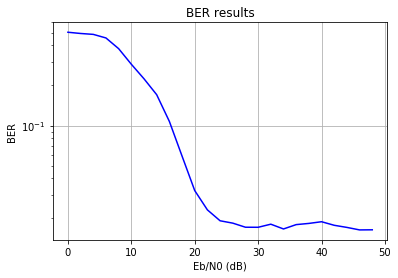

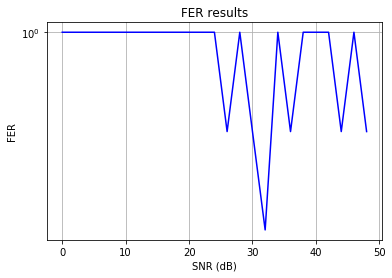

In [13]:
# Launch simulation
from MonteCarlo import *

# Model loading
model_path = "./models/pre_eq_model_proakis_C_20_30dB.pth"
#"./models/pre_eq_model_proakis_C_30_40dB.pth"
#"./models/pre_eq_model_proakis_C_40_50dB.pth"
#"./models/pre_eq_model_proakis_C_30_40_50dB.pth"
#"./models/pre_eq_model_proakis_C_20_30_40_50dB.pth"
#"./models/pre_eq_model_proakis_C_10_25_40dB.pth"
#"./models/pre_eq_model_proakis_C_25_40dB.pth"
#"./models/pre_eq_model_proakis_C_25dB.pth"
#"./models/pre_eq_model_proakis_C_50dB.pth"
#"./models/pre_eq_model_proakis_C_40dB.pth"
#"./models/pre_eq_model_proakis_C_30dB.pth"
#"./models/pre_eq_model_proakis_C_20dB.pth"
#"./models/pre_eq_model_proakis_C_15dB.pth"
#"./models/pre_eq_model_proakis_C.pth"
#"./models/pre_eq_model.pth"

simulation_param_dict = {
    "m_c_parameters": {
        "min_error_frame": 100,
        "targeted_fer": 1e-2,
        "step_db": 2,
        "min_eb_n0": 0,
        "max_eb_n0": 50,
    },
    "channel_parameters": {
        "channel_type": "Proakis_C",
        "non_lin_coeff": 0.5,
        "iq_imbalance": 0.5,
        "channel_taps": np.array([1, 2, 3, 2, 1]),
    },
    "frame_length": 256,
    "modulation": {
        "modulation_order": 4,
        "nb_carriers": 64,
        "cp_length": 8,
        "off_carrier": 0,
    },
    "equalizer": "MMSE",
    "channel_coding": {
        "mem_size": np.array([2]),
        "g_matrix": np.array([[0o5, 0o7]]),
        "rho": 1 / 2,  #  Coding rate
    },
    "pre_equalizer": {
        "model_path": model_path,
        "feed_back_freq": 0, # 0 => no feedback update, the training is just off-line
    }
}

# Launch the simulation
monte_carlo_simulation(simulation_param_dict, "train_20_30dB")

The next cell handle the display of the different results : Performances while training and performances comparison over AWGN and Proakis C channel.

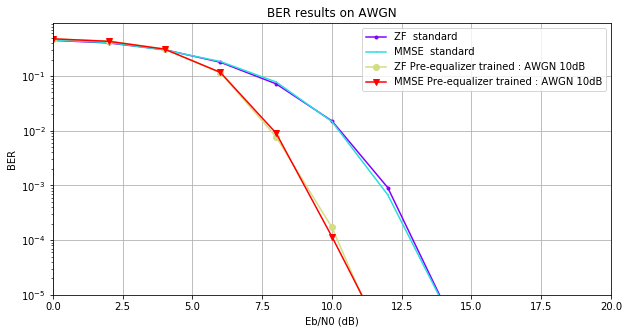

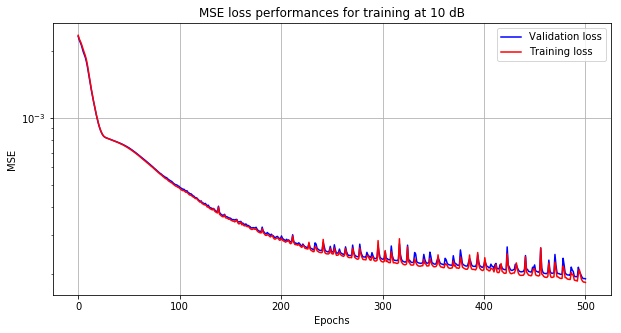

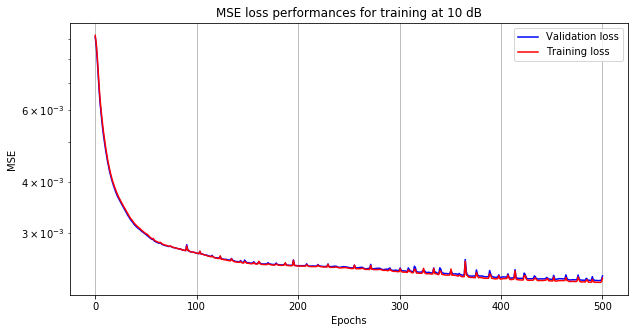

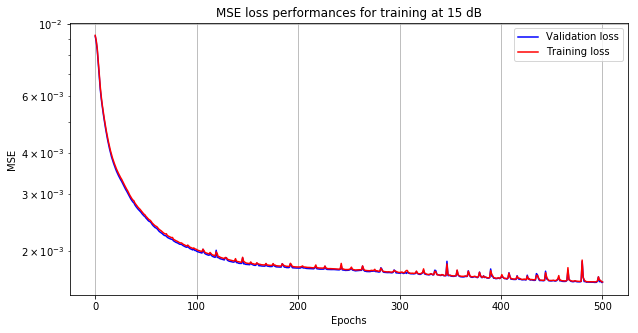

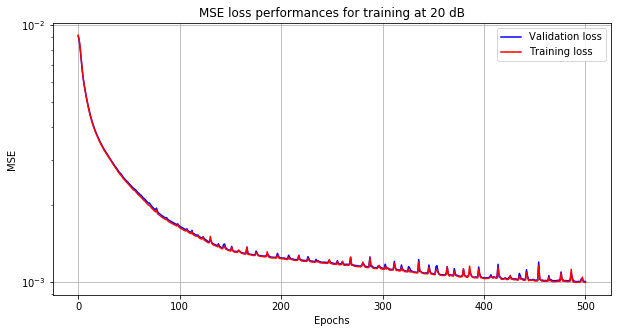

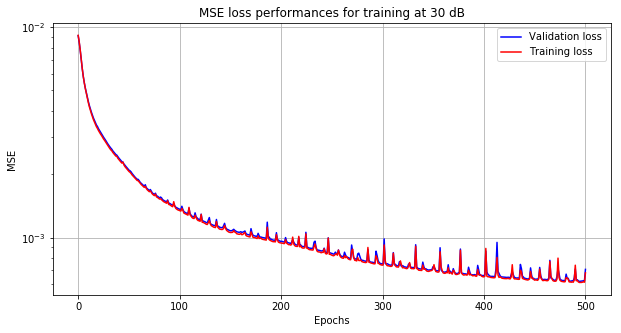

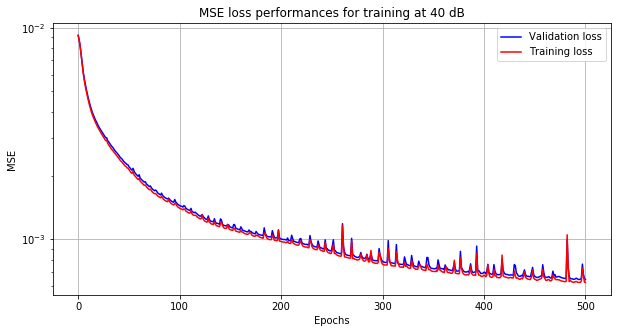

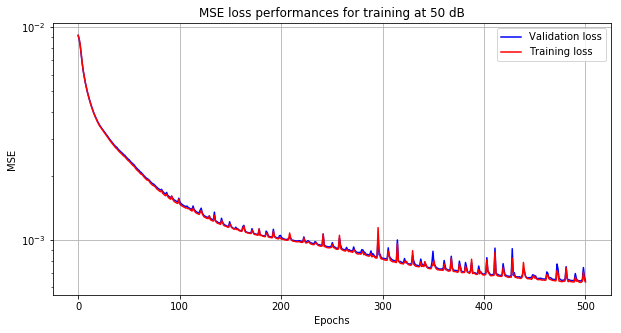

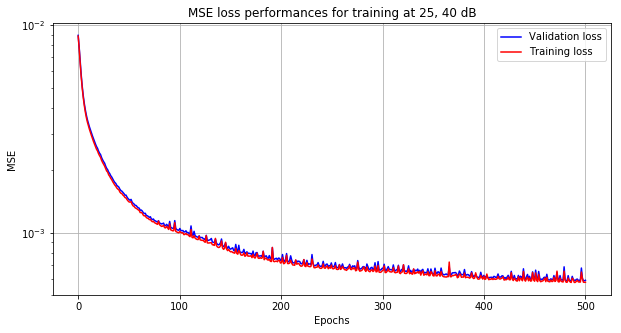

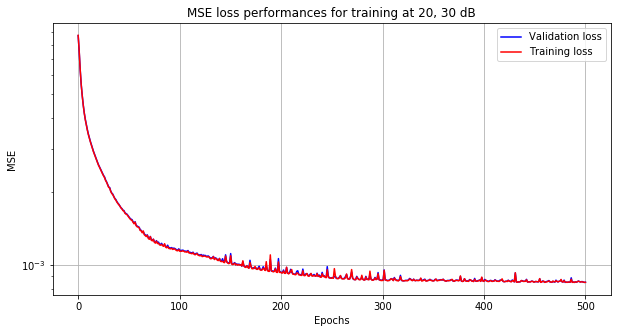

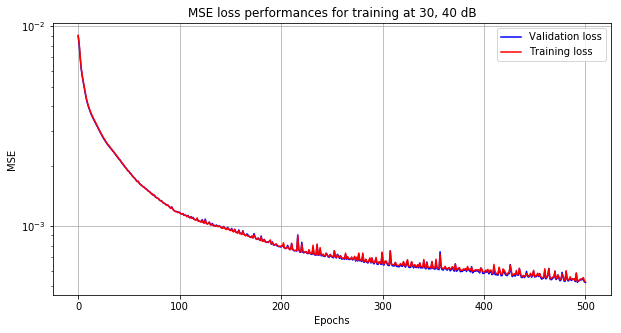

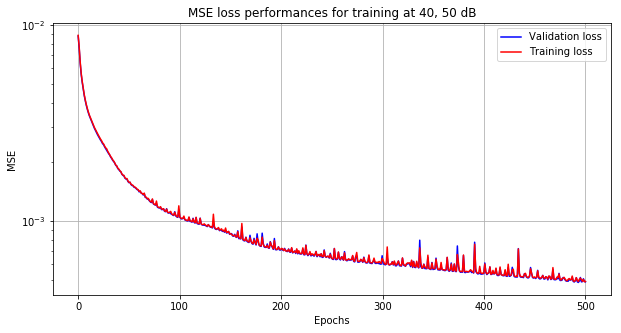

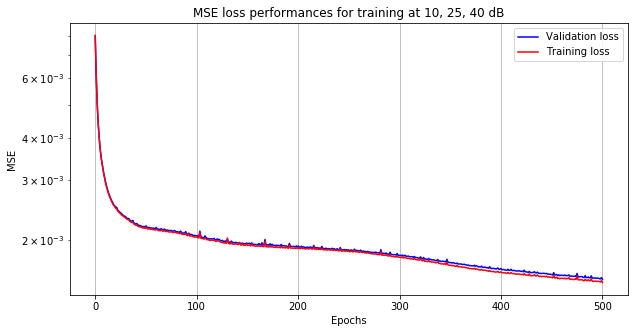

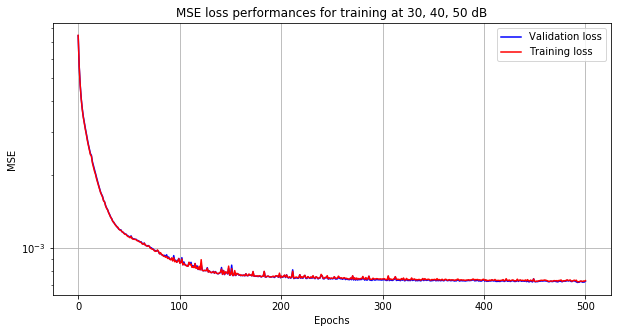

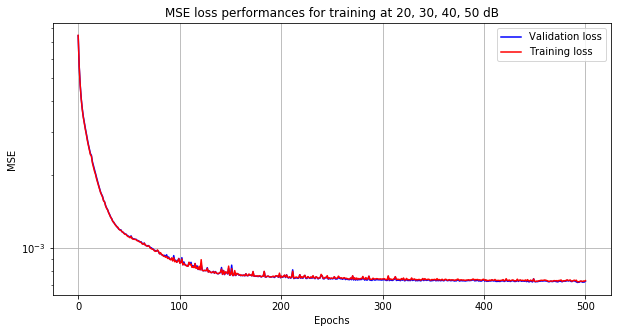

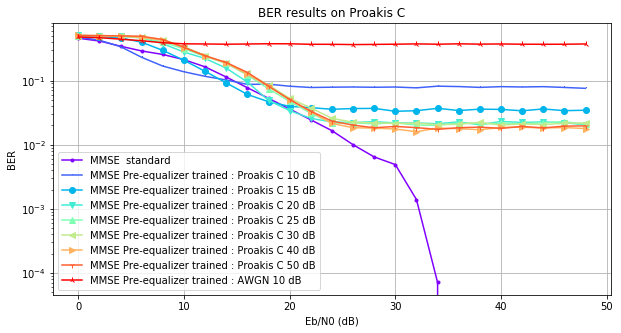

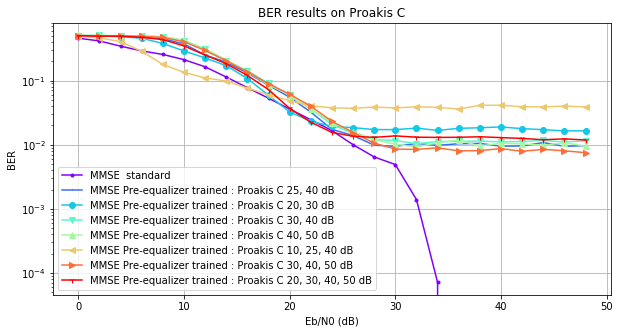

In [20]:
#  Print of performances
from Utils import *
import matplotlib2tikz

# Plot AWGN
res_MMSE = load_results(
    "./results/OFDM_eq_MMSE_coding_0.5_AWGN_non_lin_coeff_0.5"
    + "_iq_im_0.5_snr_0_to_50_step_2_.pickle"
)
res_ZF = load_results(
    "./results/OFDM_eq_ZF_coding_0.5_AWGN_non_lin_coeff_0.5"
    + "_iq_im_0.5_snr_0_to_50_step_2_.pickle"
)
res_ZF_pre_eq = load_results(
    "./results/OFDM_eq_ZF_coding_0.5_AWGN_non_lin_coeff_0.5"
    + "_iq_im_0.5_snr_0_to_30_step_2_pre_equalizer_update_0.pickle"
)
res_MMSE_pre_eq = load_results(
    "./results/OFDM_eq_MMSE_coding_0.5_AWGN_non_lin_coeff_0.5"
    + "_iq_im_0.5_snr_0_to_30_step_2_pre_equalizer_update_0.pickle"
)

# Plot perfoamnces AWGN
output_path_performances = "./results/figures/AWGN_performances.tex"
plot_performance(
    [res_ZF, res_MMSE, res_ZF_pre_eq, res_MMSE_pre_eq],
    ["standard", "standard", "trained : AWGN 10dB", "trained : AWGN 10dB"],
    output_path=output_path_performances,
    max_eb_n0=20,
)

# Load validation and training performances : AWGN
output_path_training = "./results/figures/pre_eq_model_train_AWGN.tex"
perf_epochs = load_results("./models/pre_eq_model_training_perf.pickle")
plot_training_performances(perf_epochs, "10 dB", output_path=output_path_training)

# Load validation and training performances : Proakis C 10dB
output_path_training = "./results/figures/pre_eq_model_train_proakis_C_10dB.tex"
perf_epochs = load_results("./models/pre_eq_model_proakis_C_training_perf.pickle")
plot_training_performances(perf_epochs, "10 dB", output_path=output_path_training)

# Load validation and training performances : Proakis C 15dB
output_path_training = "./results/figures/pre_eq_model_train_proakis_C_15dB.tex"
perf_epochs = load_results("./models/pre_eq_model_proakis_C_15dB_training_perf.pickle")
plot_training_performances(perf_epochs, "15 dB", output_path=output_path_training)

# Load validation and training performances : Proakis C 20dB
output_path_training = "./results/figures/pre_eq_model_train_proakis_C_20dB.tex"
perf_epochs = load_results("./models/pre_eq_model_proakis_C_20dB_training_perf.pickle")
plot_training_performances(perf_epochs, "20 dB", output_path=output_path_training)

# # Load validation and training performances : Proakis C 25dB
# output_path_training = "./results/figures/pre_eq_model_train_proakis_C_25dB.tex"
# perf_epochs = load_results("./models/pre_eq_model_proakis_C_25dB_training_perf.pickle")
# plot_training_performances(perf_epochs, "25 dB", output_path=output_path_training)

# Load validation and training performances : Proakis C 30dB
output_path_training = "./results/figures/pre_eq_model_train_proakis_C_30dB.tex"
perf_epochs = load_results("./models/pre_eq_model_proakis_C_30dB_training_perf.pickle")
plot_training_performances(perf_epochs, "30 dB", output_path=output_path_training)

# Load validation and training performances : Proakis C 40dB
output_path_training = "./results/figures/pre_eq_model_train_proakis_C_40dB.tex"
perf_epochs = load_results("./models/pre_eq_model_proakis_C_40dB_training_perf.pickle")
plot_training_performances(perf_epochs, "40 dB", output_path=output_path_training)

# Load validation and training performances : Proakis C 50dB
output_path_training = "./results/figures/pre_eq_model_train_proakis_C_50dB.tex"
perf_epochs = load_results("./models/pre_eq_model_proakis_C_50dB_training_perf.pickle")
plot_training_performances(perf_epochs, "50 dB", output_path=output_path_training)

# Load validation and training performances : Proakis C 25 and 40dB
output_path_training = "./results/figures/pre_eq_model_train_proakis_C_25_40dB.tex"
perf_epochs = load_results(
    "./models/pre_eq_model_proakis_C_25_40dB_training_perf.pickle"
)
plot_training_performances(perf_epochs, "25, 40 dB", output_path=output_path_training)



# Load validation and training performances : Proakis C 20 and 30dB
output_path_training = "./results/figures/pre_eq_model_train_proakis_C_20_30dB.tex"
perf_epochs = load_results(
    "./models/pre_eq_model_proakis_C_20_30dB_training_perf.pickle"
)
plot_training_performances(
    perf_epochs, "20, 30 dB", output_path=output_path_training
)

# Load validation and training performances : Proakis C 30 and 40dB
output_path_training = "./results/figures/pre_eq_model_train_proakis_C_30_40dB.tex"
perf_epochs = load_results(
    "./models/pre_eq_model_proakis_C_30_40dB_training_perf.pickle"
)
plot_training_performances(
    perf_epochs, "30, 40 dB", output_path=output_path_training
)

# Load validation and training performances : Proakis C 40 and 50dB
output_path_training = "./results/figures/pre_eq_model_train_proakis_C_40_50dB.tex"
perf_epochs = load_results(
    "./models/pre_eq_model_proakis_C_40_50dB_training_perf.pickle"
)
plot_training_performances(
    perf_epochs, "40, 50 dB", output_path=output_path_training
)

# Load validation and training performances : Proakis C 10, 25 and 40dB
output_path_training = "./results/figures/pre_eq_model_train_proakis_C_10_25_40dB.tex"
perf_epochs = load_results(
    "./models/pre_eq_model_proakis_C_10_25_40dB_training_perf.pickle"
)
plot_training_performances(
    perf_epochs, "10, 25, 40 dB", output_path=output_path_training
)


# Load validation and training performances : Proakis C 30 40 and 50dB
output_path_training = "./results/figures/pre_eq_model_train_proakis_C_30_40_50dB.tex"
perf_epochs = load_results(
    "./models/pre_eq_model_proakis_C_20_30_40_50dB_training_perf.pickle"
)
plot_training_performances(
    perf_epochs, "30, 40, 50 dB", output_path=output_path_training
)

# Load validation and training performances : Proakis C 20 30 40 and 50dB
output_path_training = (
    "./results/figures/pre_eq_model_train_proakis_C_20_30_40_50dB.tex"
)
perf_epochs = load_results(
    "./models/pre_eq_model_proakis_C_20_30_40_50dB_training_perf.pickle"
)
plot_training_performances(
    perf_epochs, "20, 30, 40, 50 dB", output_path=output_path_training
)


# Plot Proakis C
output_path_performances = "./results/figures/Proakis_C_performances.tex"
res_MMSE_pro = load_results(
    "./results/OFDM_eq_MMSE_coding_0.5_Proakis_C_non_lin_coeff_0"
    + "_iq_im_None_snr_0_to_50_step_2_.pickle"
)
res_MMSE_pro_pre_eq = load_results(
    "./results/OFDM_eq_MMSE_coding_0.5_Proakis_C_non_lin_coeff_0.5"
    + "_iq_im_0.5_snr_0_to_50_step_2_pre_equalizer_update_0.pickle"
)

res_MMSE_pro_pre_eq_15dB = load_results(
    "./results/OFDM_eq_MMSE_coding_0.5_Proakis_C_non_lin_coeff_0.5"
    + "_iq_im_0.5_snr_0_to_50_step_2_pre_equalizer_update_0_train_15dB.pickle"
)

res_MMSE_pro_pre_eq_20dB = load_results(
    "./results/OFDM_eq_MMSE_coding_0.5_Proakis_C_non_lin_coeff_0.5"
    + "_iq_im_0.5_snr_0_to_50_step_2_pre_equalizer_update_0_train_20dB.pickle"
)

res_MMSE_pro_pre_eq_25dB = load_results(
    "./results/OFDM_eq_MMSE_coding_0.5_Proakis_C_non_lin_coeff_0.5"
    + "_iq_im_0.5_snr_0_to_50_step_2_pre_equalizer_update_0_train_25dB.pickle"
)

res_MMSE_pro_pre_eq_30dB = load_results(
    "./results/OFDM_eq_MMSE_coding_0.5_Proakis_C_non_lin_coeff_0.5"
    + "_iq_im_0.5_snr_0_to_50_step_2_pre_equalizer_update_0_train_30dB.pickle"
)

res_MMSE_pro_pre_eq_40dB = load_results(
    "./results/OFDM_eq_MMSE_coding_0.5_Proakis_C_non_lin_coeff_0.5"
    + "_iq_im_0.5_snr_0_to_50_step_2_pre_equalizer_update_0_train_40dB.pickle"
)

res_MMSE_pro_pre_eq_50dB = load_results(
    "./results/OFDM_eq_MMSE_coding_0.5_Proakis_C_non_lin_coeff_0.5"
    + "_iq_im_0.5_snr_0_to_50_step_2_pre_equalizer_update_0_train_50dB.pickle"
)


# Several points of SNR
res_MMSE_pro_pre_eq_25_40dB = load_results(
    "./results/OFDM_eq_MMSE_coding_0.5_Proakis_C_non_lin_coeff_0.5"
    + "_iq_im_0.5_snr_0_to_50_step_2_pre_equalizer_update_0_train_25_40dB.pickle"
)

res_MMSE_pro_pre_eq_20_30dB = load_results(
    "./results/OFDM_eq_MMSE_coding_0.5_Proakis_C_non_lin_coeff_0.5"
    + "_iq_im_0.5_snr_0_to_50_step_2_pre_equalizer_update_0_train_20_30dB.pickle"
)

res_MMSE_pro_pre_eq_30_40dB = load_results(
    "./results/OFDM_eq_MMSE_coding_0.5_Proakis_C_non_lin_coeff_0.5"
    + "_iq_im_0.5_snr_0_to_50_step_2_pre_equalizer_update_0_train_30_40dB.pickle"
)

res_MMSE_pro_pre_eq_40_50dB = load_results(
    "./results/OFDM_eq_MMSE_coding_0.5_Proakis_C_non_lin_coeff_0.5"
    + "_iq_im_0.5_snr_0_to_50_step_2_pre_equalizer_update_0_train_40_50dB.pickle"
)

res_MMSE_pro_pre_eq_10_25_40dB = load_results(
    "./results/OFDM_eq_MMSE_coding_0.5_Proakis_C_non_lin_coeff_0.5"
    + "_iq_im_0.5_snr_0_to_50_step_2_pre_equalizer_update_0_train_10_25_40dB.pickle"
)

res_MMSE_pro_pre_eq_30_40_50dB = load_results(
    "./results/OFDM_eq_MMSE_coding_0.5_Proakis_C_non_lin_coeff_0.5"
    + "_iq_im_0.5_snr_0_to_50_step_2_pre_equalizer_update_0_train_30_40_50dB.pickle"
)

res_MMSE_pro_pre_eq_20_30_40_50dB = load_results(
    "./results/OFDM_eq_MMSE_coding_0.5_Proakis_C_non_lin_coeff_0.5"
    + "_iq_im_0.5_snr_0_to_50_step_2_pre_equalizer_update_0_train_20_30_40_50dB.pickle"
)

res_MMSE_pro_pre_eq_awgn_10dB = load_results(
    "./results/OFDM_eq_MMSE_coding_0.5_Proakis_C_non_lin_coeff_0.5"
    + "_iq_im_0.5_snr_0_to_50_step_2_pre_equalizer_update_0_train_awgn_10dB.pickle"
)


plot_performance(
    [
        res_MMSE_pro,
        res_MMSE_pro_pre_eq,
        res_MMSE_pro_pre_eq_15dB,
        res_MMSE_pro_pre_eq_20dB,
        res_MMSE_pro_pre_eq_25dB,
        res_MMSE_pro_pre_eq_30dB,
        res_MMSE_pro_pre_eq_40dB,
        res_MMSE_pro_pre_eq_50dB,
        res_MMSE_pro_pre_eq_awgn_10dB,
    ],
    [
        "standard",
        "trained : Proakis C 10 dB",
        "trained : Proakis C 15 dB",
        "trained : Proakis C 20 dB",
        "trained : Proakis C 25 dB",
        "trained : Proakis C 30 dB",
        "trained : Proakis C 40 dB",
        "trained : Proakis C 50 dB",
        "trained : AWGN 10 dB",
    ],
    output_path=output_path_performances,
)

# Plot in the case of several point of training SNR
plot_performance(
    [
        res_MMSE_pro,
        res_MMSE_pro_pre_eq_25_40dB,
        res_MMSE_pro_pre_eq_20_30dB,
        res_MMSE_pro_pre_eq_30_40dB,
        res_MMSE_pro_pre_eq_40_50dB,
        res_MMSE_pro_pre_eq_10_25_40dB,
        res_MMSE_pro_pre_eq_30_40_50dB,
        res_MMSE_pro_pre_eq_20_30_40_50dB,
    ],
    [
        "standard",
        "trained : Proakis C 25, 40 dB",
        "trained : Proakis C 20, 30 dB",
        "trained : Proakis C 30, 40 dB",
        "trained : Proakis C 40, 50 dB",
        "trained : Proakis C 10, 25, 40 dB",
        "trained : Proakis C 30, 40, 50 dB",
        "trained : Proakis C 20, 30, 40, 50 dB",
    ],
    output_path="./results/figures/Proakis_C_performances_n_SNR_train.tex",
)